# EEG Prepocessing in Python
### Group members: Yen-Chen Lu & Tsu-Yueh Hsu

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs)

In [2]:
%matplotlib qt

## Open dataset (OpenNeuro)
### __[EEG data from an auditory oddball task](https://openneuro.org/datasets/ds003061/versions/1.1.2)__


- 3 identical sessions (13 min each)
- 750 stimuli
    - 70% standard (500 Hz pure tone, 60 ms)
    - 15% oddball (1000 Hz pure tone, 60 ms)
    - 15% distractors (1000 Hz white noise, 60 ms)
- Respond to oddball by pressing a key

## Read the raw data

In [3]:
# Read the set file
raw_path = './oddball/sub-001/eeg'
raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
raw

<ipython-input-3-4f50d6a8048b>:3: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
<ipython-input-3-4f50d6a8048b>:3: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 79 x 194048 (758.0 s), ~117.1 MB, data loaded>

In [4]:
# Visualize the raw data
%matplotlib qt
raw.plot();

Using matplotlib as 2D backend.
Channels marked as bad:
none


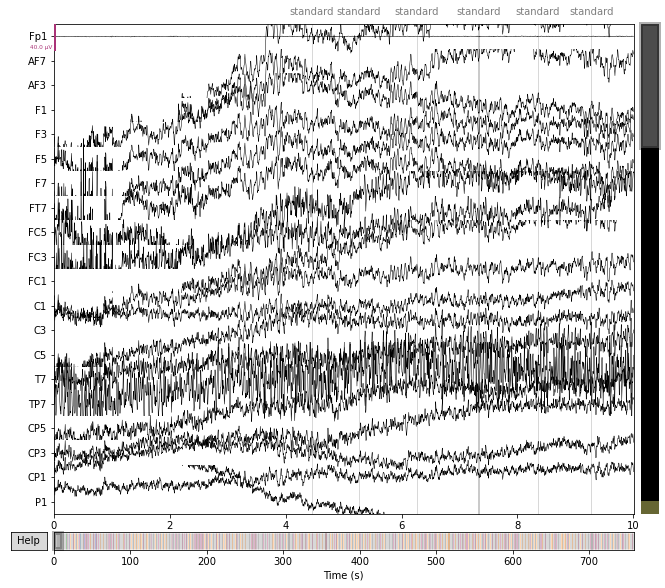

In [5]:
# Visualize the raw data
%matplotlib inline
raw.plot();

## Select only a subset of the channels

In [6]:
# Number of channels before subsetting
len(raw.ch_names)

79

In [7]:
# Show all channels before subsetting
', '.join(raw.ch_names)

'Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2, EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, GSR1, GSR2, Erg1, Erg2, Resp, Plet, Temp'

In [8]:
# Select only a subset of the channels
raw_eeg = raw.copy()
raw_eeg.pick_types(meg = False, eeg = True, eog = True, exclude = [])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

In [9]:
# Number of channels after subsetting
len(raw_eeg.ch_names)

65

In [10]:
# Show the subset of the channels
', '.join(raw_eeg.ch_names)

'Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2, Temp'

## Visualize the sensor locations

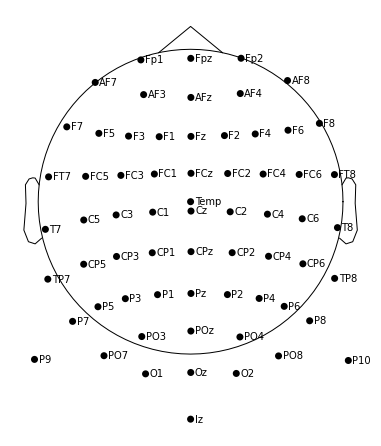

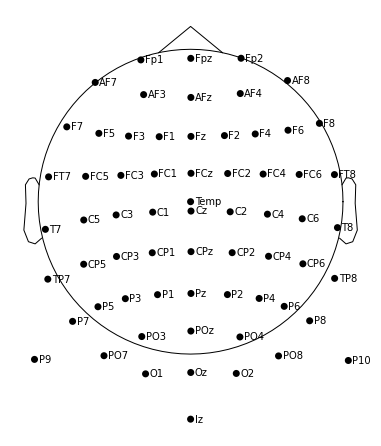

In [11]:
# In 2D
mne.viz.plot_sensors(raw.info, kind = 'topomap', ch_type = 'all', show_names = True)

## Referencing
We choose T7 and T8 as our referenced electrodes for our data. (Since there are no M1 and M2 channels in our data.)

In [12]:
# Referencing using the T7, T8 channels as the referenced electrode
raw_ref = raw_eeg.copy()
raw_ref.set_eeg_reference(ref_channels = ['T7', 'T8'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

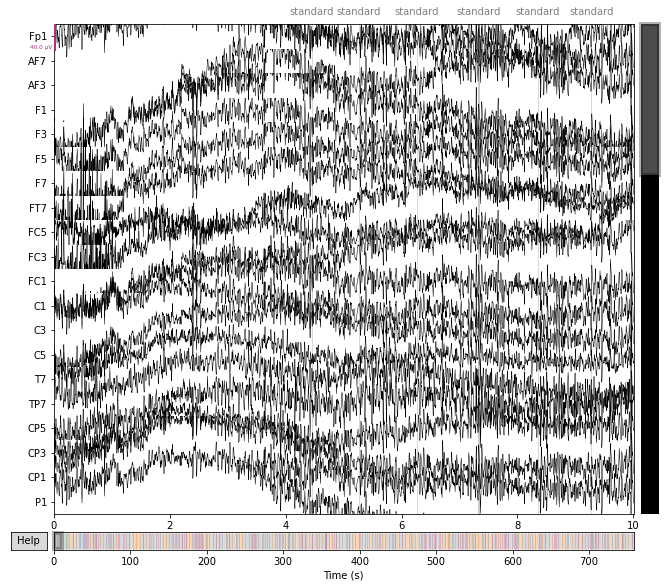

In [13]:
raw_ref.plot();

## Filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


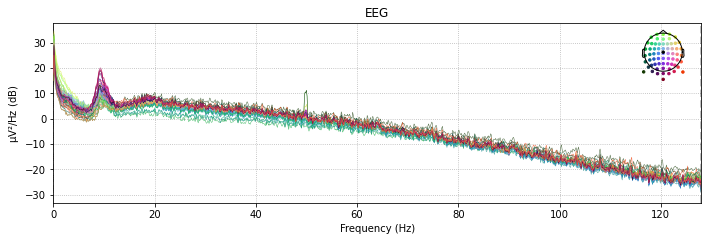

In [15]:
# Plot the power spectrum before filtering
raw_ref.plot_psd();

In [16]:
# Using a band pass filter from 1-30 Hz
raw_filtered = raw_ref.copy()
raw_filtered = raw_filtered.filter(l_freq = 0.16, h_freq = 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


### Compare before and after filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


<ipython-input-17-1b5608bb4d25>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


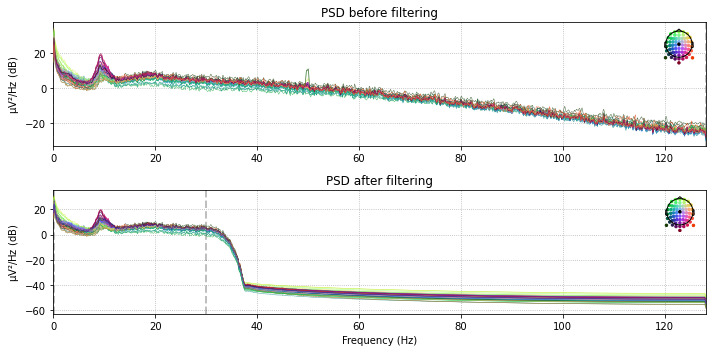

In [17]:
fig, ax = plt.subplots(2, figsize = (10,5))

# Plot PSD before filtering
raw_ref.plot_psd(ax = ax[0], picks = ['eeg'], show = False)
ax[0].set_title('PSD before filtering')

# Plot PSD after filtering
raw_filtered.plot_psd(ax = ax[1], picks = ['eeg'], show = False)
ax[1].set_title('PSD after filtering')

# Set x-axis label
ax[1].set_xlabel('Frequency (Hz)')

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

### Zoom in 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


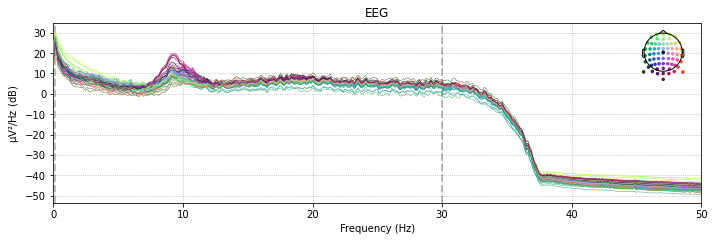

In [19]:
raw_filtered.plot_psd(fmax = 50);

## Extract events from annotations

In [20]:
# Get events and event ids from annotations
events, event_id = mne.events_from_annotations(raw_filtered)

Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']


## Creating epochs for the events

In [21]:
# Rejecting epochs with peak-to-peak amplitude +/-100 µV
reject_criteria = dict(
    eeg = 100e-6,  # 100 µV
)  

In [22]:
# Epochs will start 300 ms before the stimulus onset and end 
# 500 ms after stimulus onset
tmin = -0.2
tmax = 0.6
baseline = (None, 0)

epochs = mne.Epochs(raw_filtered,
                    events = events,
                    event_id = event_id,
                    reject = reject_criteria,
                    tmin = tmin,
                    tmax = tmax,
                    baseline = baseline,
                    preload = True)
epochs

Not setting metadata
863 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['FT7', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC3', 'FC1', 'C1', 'C3', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 

    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['P9', 'AF8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'FC3', 'FC1', 'P7', 'P9', 'PO3', 'O1', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4']
    Rejecting  epoch based on EEG : ['F1', 'FC1', 'Fp2', 'FC4', 'FCz']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'PO7', 'O1', 'POz', 'Fp2', 'FC4']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'AF4', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['PO3', 'P4', 'P6', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fp2', 'AF8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P2', 'PO

    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P9', 'O1']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'PO7', 'FC2']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecti

Number of events,611
Events,ignore: 0noise: 84noise_with_reponse: 1oddball: 0oddball_with_reponse: 84response: 67standard: 375
Time range,-0.199 – 0.602 s
Baseline,-0.199 – 0.000 s


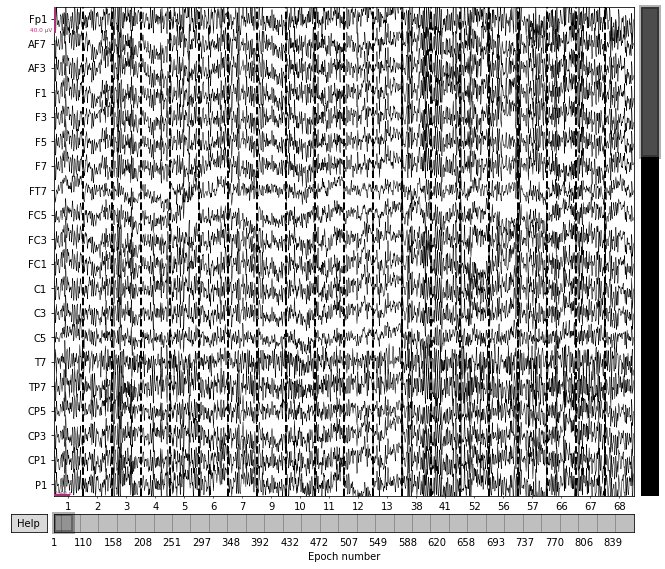

In [23]:
epochs.plot();

Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


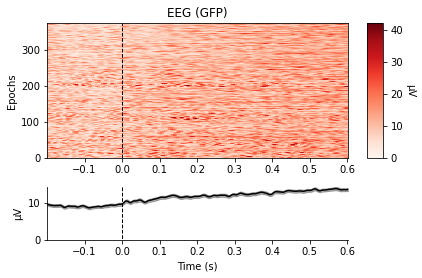

[<Figure size 432x288 with 3 Axes>]

In [24]:
%matplotlib inline
epochs['standard'].plot_image()

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


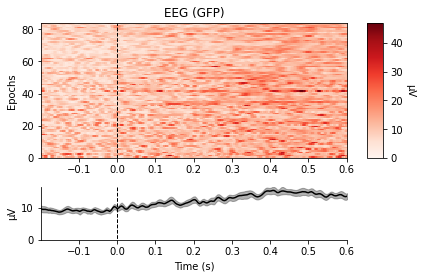

[<Figure size 432x288 with 3 Axes>]

In [25]:
%matplotlib inline
epochs['oddball_with_reponse'].plot_image()

## Creating evoked data

Creating evoked responses for each condition

In [26]:
evoked_standard = epochs['standard'].average()
evoked_oddball_resp = epochs['oddball_with_reponse'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


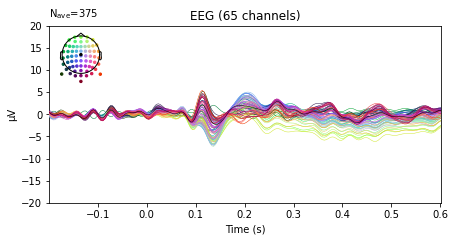

In [29]:
mne.viz.plot_evoked(evoked_standard, spatial_colors = True, ylim = dict(eeg = [-20, 20]));

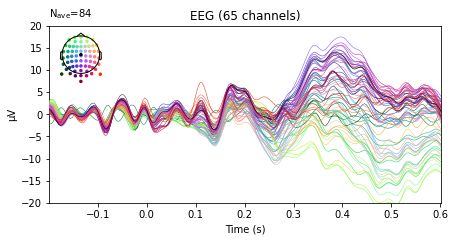

In [30]:
mne.viz.plot_evoked(evoked_oddball_resp, spatial_colors = True, ylim = dict(eeg = [-20, 20]));

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


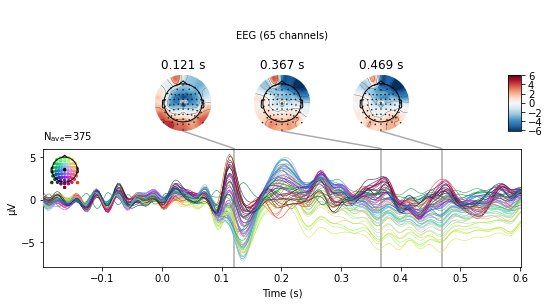

In [31]:
evoked_standard.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


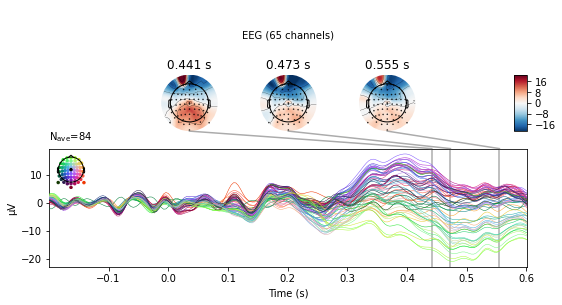

In [32]:
evoked_oddball_resp.plot_joint();

combining channels using "gfp"
combining channels using "gfp"


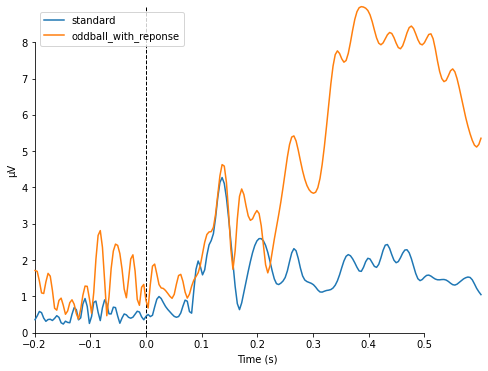

In [33]:
mne.viz.plot_compare_evokeds([evoked_standard, evoked_oddball_resp]);

## Preprocessing function

In [34]:
def eeg_prepross(subj, run):
    # get subj number (e.g., 001, 002, 003...)
    sub_num = subj
    
    # Read the set file
    raw_path = f"./oddball/sub-{sub_num}/eeg"
    raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
    
    # Select only a subset of the channels (only EEG channels)
    raw_eeg = raw.copy()
    raw_eeg.pick_types(meg = False, eeg = True, eog = True, exclude = [])
    
    # Referencing using the T7, T8 channels as the referenced electrode
    raw_ref = raw_eeg.copy()
    raw_ref.set_eeg_reference(ref_channels = ['T7', 'T8'])
    
    # Using a band pass filter from 0.16-30 Hz
    raw_filtered = raw_ref.copy()
    raw_filtered = raw_filtered.filter(l_freq = 0.16, h_freq = 30)
    
    # Get events and event ids from annotations
    events, event_id = mne.events_from_annotations(raw_filtered)
    
    # Create epoch for the events
    # Epochs will start 200 ms before the stimulus onset and end 
    # 600 ms after stimulus onset
    tmin = -0.2
    tmax = 0.6
    baseline = (None, 0)
    
    # Rejecting epochs with peak-to-peak amplitude +/-100 µV
    reject_criteria = dict(
        eeg = 100e-6,  # 100 µV
    )  

    epochs = mne.Epochs(raw_filtered,
                        events = events,
                        event_id = event_id,
                        reject = reject_criteria,
                        tmin = tmin,
                        tmax = tmax,
                        baseline = baseline,
                        preload = True)
    
    evoked_standard = epochs['standard'].average()
    evoked_oddball_resp = epochs['oddball_with_reponse'].average() 
    
    return(evoked_standard, evoked_oddball_resp)
       

In [ ]:
# Loop over all 13 subjects to do the pre-processing for all three runs

evoked_dict = {}
# {
#     '001': [run1, run2, run3],
#     '002': [run1, run2, run3], 
#     ...
#     '013': [run1, run2, run3]

# }

# run1[0] = standard
# run1[1] = oddball

sub_index = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013']
runs = range(1, 4)

for subj in sub_index:
    subj_runs = []
    for run in runs:
        subj_runs.append(eeg_prepross(subj, run))
    evoked_dict[subj] = subj_runs


<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
863 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['FT7', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1

    Rejecting  epoch based on EEG : ['P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F4', 'F6', 'F8', 'FC4', 'FC2', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['P9', 'AF8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'FC3', 'FC1', 'P7', 'P9', 'PO3', 'O1', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4']
    Rejecting  epoch based on EEG : ['F1', 'FC1', 'Fp2', 'FC4', 'FCz']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'PO7', 'O1', 'POz', 'Fp2', 'FC4']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'AF4', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on 

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['TP7', 'P9', 'PO7', 'AF8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['POz', 'Fp2', 'AF8', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'Oz', 'Fpz', 'AF8', 'AF4', 'AFz', 'F2', 'F8', 'FT8', 'FC6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'noise_with_reponse', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF8', 'Cz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF8', 'F8', 'FC2']
    Rejecting  epoch based on EEG : ['PO7', 'O1', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['C3', 'Pz']
    Rejecting

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F1']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FT7', 'P9', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'FC4', 'Cz', 'C2', 'C6', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'FT7', 'Fpz', 'F

    Rejecting  epoch based on EEG : ['O1', 'Oz', 'PO8', 'PO4', 'O2']


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['PO7', 'PO3', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO7', 'O1', 'Iz', 'Oz', 'POz', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P8']
    Rejecting  epoch based on EEG : ['PO7', 'O1']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
812 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 812 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'AF8', 'FC2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch ba

    Rejecting  epoch based on EEG : ['FT7', 'P7', 'P10']
    Rejecting  epoch based on EEG : ['FC2', 'TP8']
    Rejecting  epoch based on EEG : ['F4', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'FC2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['P7', 'P10']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'AF8']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'P10']
    Rejec

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P5', 'FC2']
    Rejecting  epoch based on EEG : ['AF8', 'FC2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['P5', 'FC2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'AF8', 'F6', 'FC2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC4', 'FC2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'Fp2', 'FC2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'FT7', 'FC5', 'P5', 'P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1

    Rejecting  epoch based on EEG : ['F1', 'P7', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'P7', 'F6']
    Rejecting  epoch based on EEG : ['F1', 'FC5', 'P7', 'PO7', 'AF8', 'F6', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['F1', 'F3', 'FC5', 'P7', 'P9', 'AF8', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['F1', 'FC5', 'P7', 'P9', 'AF8', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['F1', 'FC5', 'P7', 'P9', 'AF8', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['F1', 'FC5', 'P7', 'AF8', 'F4']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'AF8']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['P7', 'F6']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'P7', 'P9', 'Oz', 'Fp2', 'AF8', 'F6', 'FC4', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'Oz']
    Rejecting  epoch based on EEG : ['P5', 'Oz', 'F6', 'FC4', 'FC2']
    Reje

    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['FC2', 'P10']
    Rejecting  epoch based on EEG : ['FC2', 'TP8']
    Rejecting  epoch based on EEG : ['FC2', 'TP8']
    Rejecting  epoch based on EEG : ['F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P5', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC5', 'FC2']
    Rejecting  epoch based on EEG : ['FC2', 'TP8']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['FC4', 'FC2']
    Rejecting  epoch based on EEG : ['FC4', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'F6', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['FC4', 'FC2', 'C2']

    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'FC3', 'C5', 'CP5', 'P7', 'Iz', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'P6', 'P8', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6

    Rejecting  epoch based on EEG : ['P7', 'Oz', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['AF3', 'P5', 'P7', 'AF8', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'P7', 'AF8', 'FC4', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'FC4', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['AF8', 'FC4', 'FC2', 'C2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF8', 'FC4', 'FC2', 'C2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['P7', 'FC4', 'FC2', 'C2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'F6', 'FC4', 'FC2', 'C2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'P7', 'AF8', 'F4', 'F6', 'FC4', 'FC2', 'C

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-34-8e0392dd11c5>:46: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked_oddball_resp = epochs['oddball_with_reponse'].average()
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
807 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 807 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF3', 'P7', 'TP8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['P7', 'POz', 'AF8', 'PO4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['AF8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'F4', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Iz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'AF8', 'FT8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'P7', 'Fpz', 'Fp2', 'AF8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'AF8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting 

    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fpz', 'Fz', 'TP8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'F2', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'F2', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fz', 'TP8']
    Rejecting  epoch based on EEG : ['Fz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['FC1', 'P7', 'Fz', 'F2', 'FCz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Iz', 'Fz', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F

    Rejecting  epoch based on EEG : ['FT7', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['Oz', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz',

    Rejecting  epoch based on EEG : ['FT7', 'P7', 'AF8', 'Fz', 'C4', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['FT7', 'P7']
    Rejecting  epoch based on EEG : ['FT7', 'Fz', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'F6', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'FC1', 'P7', 'Iz', 'Fz', 'FCz']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Oz', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'TP8'

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Oz', 'AF8', 'F4', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fz']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Fz', 'F4', 'TP8', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'P7', 'Fz', 'FT8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'TP8', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'P7', 'Fz', 'TP8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'P7', 'PO4']
    Rejecting

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
799 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 799 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'F6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'C4']
    Rejecting  epoch based on EEG : ['P

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'Fp2', 'F6']
    Rejecting  epoch based on EEG : ['P7', 'FT8', 'P8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'C4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on 

    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'F2', 'PO4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['F1', 'FC1', 'P7', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['CP5', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'PO7']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', '

    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'P7', 'P9', 'Oz', 'Fpz', 'AF8', 'F2', 'F4', 'F6', 'FT8', 'FC6', 'P4', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Oz', 'F6', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Oz', 'Fp2', 'AF8', 'F2', 'F4', 'F6', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Iz', 'Oz', 'F6', 'FT8', 'TP8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'PO7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'F6', 'FT8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F4', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'O2']
    Rejecting  epoch based on EEG : ['F1', 'P7', 'Fz', 'F2', 'FCz']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF7', 'P5', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'F8']
    Rejecting  epoch based on EEG : ['P7', 'AF8']
    Rejecting  epoch based on EEG : ['F5', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8']
    Rejecting  epoch based on EEG : ['F5', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'P6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fp2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
861 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch bas

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['F5', 'FT8']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F1', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FCz']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['F1', 'AFz', 'Fz', 'F2', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'AF4', 'AFz', 'Fz', 'F2']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'FC2']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['F5', 'C5', 'FC2']
    Rejecting  epoc

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'FC2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'FC2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'F2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fpz', 'Fp2']
    Re

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'AFz', 'Fz', 'F2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2', 'P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4', 'P4']
    Rejecting  epoch based on EEG : ['P

    Rejecting  epoch based on EEG : ['FC3', 'CP5', 'POz', 'AF4', 'Fz', 'F2', 'F4', 'F8', 'FT8', 'FC2', 'P2', 'P4', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['POz', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'FT8', 'FC2', 'P2', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'POz', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC2', 'C6', 'P10']
    Rejecting  epoch based on EEG : ['FC1', 'POz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC2', 'FCz', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['POz', 'AF8', 'FT8', 'FC2', 'P6']
    Rejecting  epoch based on EEG : ['F5', 'POz', 'Pz', 'F2', 'FC2', 'P2', 'P10']
    Rejecting  epoch based on EEG : ['O1', 'POz', 'AF8', 'AF4', 'FT8', 'FC2', 'PO8']
    Rejecting  epoch based on EEG : ['POz', 'FT8', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz', 'F4', 'FT8']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['F5', 'FC2', 'P2', 'P

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
861 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['F3', 'F2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['Fpz',

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F4', 'P6', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['Fz', 'F2']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['Fpz', 'F2']
    Rejecting  epoch based on EEG : ['F5', 'F2', 'P6']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'FC1', 'Fpz', 'AFz', 'Fz', 'F2', 'FCz', 'P4']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'Fz']
    Rejecting  epoch based on EEG : ['F1', 'AF8', 'AF4', 'Fz', 'F2', 'F4']
    Rejecting  epoch based on EEG : ['F1', 'F3', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz',

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'F6', 'FT8', 'C4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'F2', 'F6', 'FT8', 'FC4', 'C4']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'P6']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FC1', 'C1', 'CP5', 'CP3', 'P3', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fz', 'F2', 'F6', 'FT8', 'FCz', 'Cz', 'C4', 'CP4']
    Rejec

    Rejecting  epoch based on EEG : ['F5', 'C3', 'FT8', 'C4']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'F7', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'C1', 'C3', 'CP3', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FT8', 'C4']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'Fz', 'F6', 'FT8', 'FC2', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'CP3']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C1', 'C3', 'CP3', 'Fpz', 'AFz', 'Fz', 'FT8', 'Cz', 'CP4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C1', 'C3', 'CP3', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'F6', 'FT8', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'Fpz', 'Fz']
    Rejecting  epoch based o

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'PO7', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F5', 'O1', 'C4']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'PO7', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'FT8']
    Rejecting  epoch based 

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C3', 'P9', 'PO7', 'O1', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'C3', 'T7', 'TP7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'FT8', 'FC6', 'FC4', 'FCz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'PO7', 'Iz', 'Fpz', 'FT8', 'C6', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Oz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Iz', 'Oz', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'P9', 'Fpz', 'Fp2', 'AFz', 

    Rejecting  epoch based on EEG : ['F5', 'F7', 'C5', 'PO3', 'O1', 'Iz', 'Fpz', 'F6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'P5', 'PO7', 'PO3', 'Iz', 'Fpz', 'AFz', 'F4', 'F6', 'FT8', 'C6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'P1', 'P5', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C6', 'CP6', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'P1', 'Iz', 'Fpz', 'F6', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Iz', 'Fpz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fpz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C5', 'T7', 'TP7', 'CP5', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2',

    Rejecting  epoch based on EEG : ['F3', 'F5']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'CP5', 'CP3', 'P9', 'PO7', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AFz', 'FT8', 'C2', 'CP6', 'CP2', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'CP3', 'Oz', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C3', 'Oz', 'Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Oz', 'Fpz', 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
857 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 857 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'T7', 'CP1', 'P1', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'FCz', 'C6', 'T8', 'CP6', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'P5', 'PO7', 'Iz', 'Fpz', 'FC4', 'FCz', 'CP2']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C3', 'P9', 'Fp2']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'PO7', 'Oz', 'Pz', 'FC4', 'FCz', 'CP2']
    Rejecting  epoch based on EE

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F7', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F7', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F7', 'P5', 'PO7', 'Iz', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'AFz', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F5', 'FC1', 'C1', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'Iz', 'Pz', 'CPz', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'CP4', 'CP2', 'P2', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'C6', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7

    Rejecting  epoch based on EEG : ['F3', 'F7', 'P9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'P9']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'P9', 'PO7', 'Fpz', 'AFz', 'FT8', 'PO4']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'P9']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'P9']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'CP1', 'P1', 'P3', 'P5', 'Iz', 'POz', 'CPz', 'Fpz', 'FT8', 'FCz', 'Cz', 'CP6', 'CP2', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'PO7', 'Iz', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Fpz', 'AF4', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'C3', 'T7', 'P1', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'C5', 'T7', 'P1', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'CP6', 'CP2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting 

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C5', 'P5', 'PO7', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'P9', 'O1', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'P9', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'P

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'AF8', 'Fz', 'F2', 'F4', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F7', 'FT7', 'FC5', 'FC1', 'C1', 'C5', 'T7', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', '

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C5', 'T7', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on 

    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F7', 'FC5', 'FC1', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'Iz', 'Pz', 'CPz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'CP6', 'CP4', 'CP2', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'FC1', 'C5', 'T7', 'P1', 'P3', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'AFz', 'Fz', 'FC4', 'FC2', 'FCz', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC1', 'C1', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4',

    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FC1', 'C1', 'C5', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fz', 'F2', 'F4', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4'

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'C1', 'C3', 'C5', 'T7', 'CP3', 'CP1', 'P3', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C4', 'C6', 'T8', 'CP4', 'P2', 'P4', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F7', 'FC1', 'C1', 'C5', 'T7', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC4', 'FC2', 'FC

    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FT7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'P1', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'C4', 'C6', 'T8', 'CP6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'FT7', 'C5', 'P9', 'PO7', 'O1', 'Fpz', 'AFz', 'F6', 'C6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'FT7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Pz', 'Fz', 'F4', 'F8', 'FC6', 'FC4', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'PO

    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'FC5', 'FC1', 'C1', 'C5', 'T7', 'CP1', 'P1', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'F4', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'FC1', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'C2', 'C6', 'CP6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'FC5', 'C5', 'T7', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'CP6', 'P6', 'P8', 'P10', 'PO8', 'O2

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'C1', 'C3', 'CP3', 'CP1', 'P3', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'FT8', 'FC6', 'FCz', 'Cz', 'C6', 'CP4', 'P4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'FC5', 'FC1', 'C1', 'C5', 'CP1', 'PO7', 'O1', 'Iz', 'Pz', 'F4', 'FC6', 'FC4', 'FCz', 'Cz', 'C2', 'C6', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF4

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'C1', 'C3', 'CP3', 'CP1', 'P3', 'P9', 'O1', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FCz', 'Cz', 'C6', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F7', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'AF4', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'FC5', 'C5', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'F2', 'F6', 'FC4', 'FCz', 'C2', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FC5', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on E

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'Cz', 'C4', 'C6', 'T8', 'CP4', 'P2', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'FT7', 'FC5', 'C1', 'C5', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fz', 'F4', 'FC4', 'FCz', 'C6', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F4', 'F6', 'FCz', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'P3', 'P9', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FCz', 'Cz', 'C2', 'C6', 'CP6', 'CP4', 'P2', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'Iz', 'C6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
861 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'CPz', 'Fp2', 'AF4', 'Fz', 'F2', 'F4', 'F8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'P9', 'PO3', 'Pz', 'Fz', 'FCz']
    Rejecting  epoch based on EEG : ['F7', 'PO7', 'Iz', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'PO7']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'FC5', 'C1', 'C3', 'CP1', 'P3', 'P5', 'P7', 'P9',

    Rejecting  epoch based on EEG : ['PO7', 'Iz', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F7', 'CP3', 'P9', 'Fpz', 'AFz', 'F6', 'FC6', 'P10']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'P1', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'T8', 'CP6', 'CP2', 'P8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fpz', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['P5', 'PO7', 'Iz', 'P8']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FC1', 'C5', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AF4', 'F4', 'F6', 'FC6', 'FC4', 'C6', 'P2', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'P1', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'CPz', 'Fpz', 'AFz', 'F2', 'F4', 'F6', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FC5', 'C1', 'C5', 'CP3', 'CP1', 'P5', 'P9', 'PO7', 'Iz', 'Pz', 'CPz', 'Fpz', 'Fp2', 

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'CP6', 'CP2', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AF4', 'F4', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F4', 'F6', 'FT8', 'C4', 'C6', 'T8', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'FC1', 'C5', 'T7', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'T8', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'P7', 'PO7', 'Iz', 'Fpz', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['Fpz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C

    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'O1']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'FC3', 'FC1', 'C5', 'T7', 'CP5', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'CPz', 'F6', 'FC4', 'Cz', 'C6', 'T8', 'CP2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F5', 'FC5', 'FC3', 'FC1', 'C5', 'T7', 'TP7', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'AFz', 'F4', 'F6', 'C2', 'C6', 'T8', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'C1', 'C5', 'CP1', 'P9', 'Iz', 'Pz', 'Fpz', 'AFz', 'Fz', 'F2', 'F6', 'CP4', 'P8']
    Rejecting  epoch based on EEG : ['FC5', 'C5', 'T7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'FC5', 'C5', 'P9', 'PO7', 'O1', 'Oz'

    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C5', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'C5', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['P9', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'C1', 'C5', 'T7', 'CP1', 'P1', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Pz', 'CPz', 'Fz', 'FC4', 'FC2', 'FCz', 'C2', 'T8', 'CP6', 'CP2', 'P2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epo

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FC5', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC2', 'Cz', 'C2', 'C4', 'C6', 'CP4', 'P2', 'P4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C1', 'C5', 'CP3', 'CP1', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'F6', 'Cz', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C5', 'T7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'CP1', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'AFz', 'F6', 'FT8', 'CP4', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'C5', 'TP7', 'CP5', 'CP3', 'P9', 'PO7', 'O1', 'Iz', 'Oz']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F

    Rejecting  epoch based on EEG : ['P3', 'Fpz', 'AFz', 'F6', 'FT8', 'C2']
    Rejecting  epoch based on EEG : ['C5', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'P9', 'Iz', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['Oz', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'FT7', 'C5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'FC6', 'C6', 'P6', 'P8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P3', 'P9', 'O1', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C2', 'C4', 'CP4', 'P2', 'P4']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F7', 'FC5', 'C5', 'T7', 'CP5', 'CP3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'FC1', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'P3', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C2', 'C4', 'CP4', 'P2', 'P4', 'P10']
    Rejecting  epoch based on EEG : ['Iz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'CP4', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'CP5'

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'C4', 'C6', 'CP6', 'CP4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C1', 'C5', 'CP5', 'CP3', 'CP1', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'C4', 'C6', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C1', 'C5', 'CP3', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C4', 'CP4', 'P8', 'PO

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'C1', 'C5', 'CP5', 'CP3', 'CP1', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'Cz', 'C2', 'C4', 'C6', 'CP4', 'P2', 'P4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'F8', 'FT8', 'C4', 'C6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'FT8', 'C4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6', 'F8', 'FT8', 'P8']
    Rejecting  epoch based on EEG : ['Pz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'P8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C5'

    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C5', 'P3', 'P5', 'P9', 'O1', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'FC6', 'C6', 'CP6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C1', 'C5', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'CP4', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'P9', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['P9', 'F6']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F4', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'CP2', 'P2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'FC1', 'C1', '

    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'FC5', 'C5', 'P1', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'CPz', 'F6', 'C6', 'CP2', 'P8', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'CP2', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'FC1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'F6', 'TP8', 'CP6', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'CP2', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'FC1', 'C5', '

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'Fz']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'Fpz', 'Fp2', 'P8']
 

    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['O1', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF3', 'P8']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'AFz', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF3', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epo

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
862 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'TP7', 'PO7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F6', 'F8', 'C6', 'CP4', 'CP2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['PO7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'Fz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'Fp2', 'P8']


    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'PO4']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['A

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
857 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 857 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
  

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Cz']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'Cz']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
855 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 855 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'P6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'CP6']
    Rejecting  epoch based on EEG :

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FC6', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC6', 'CP6']
    Rejecting  epoch based on EEG : ['FC6', 

    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F6', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F8', 'PO8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'AF8', 'AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC6']
    Rejecting  epoch based on EEG : ['AF8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']


<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
835 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 835 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['CP6', 'P8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF4', 'F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    R

    Rejecting  epoch based on EEG : ['AF4', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['F6', 'P8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['Fp2', 'AF4', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['AF8', 'F2'

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'TP7', 'AF8', 'AF4', 'F2', 'F6', 'F8', 'FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'FC6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'FC2']
    Rejecting  epoch based on EEG : ['F6', 'F8']
    Rejecting  epoch based on EEG : ['FC2']
    Reje

    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F7', 'AF4']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF4', 'F6']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF4', 'F6']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'TP7', 'AF8', 'F2', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F1']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'TP7', 'AF8', 'AF4', 'F4', 'F6', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F7', 'F6', 'FC6']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Oz']


<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
859 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 859 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F7', 'AF4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F7', 'P1', 'AF4'

    Rejecting  epoch based on EEG : ['F2', 'P6']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FC5', 'AF8', 'F2', 'F8', 'FC6', 'P2']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'FC3', 'Fpz', 'Fp2']


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'F2', 'F8']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['F2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'FC5', 'P9', 'Fpz', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'CP6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp2', 'FT8', 'FC4', 'C6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'AF4', 'AFz', 'F2', 'F4', 'FT8', 'FC4']
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'TP7', 'P9', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'F8', 'FT8', 'FC4', 'P10', 'PO8']
    Rejecting  ep

    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'P9', 'AF8', 'AFz', 'F2', 'F4', 'F8', 'FC2', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['FC5', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['C3', 'Fp2', 'AF8', 'F6', 'F8', 'FC4']
    Rejecting  epoch based on EEG : ['AF8', 'F2', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['AF8', 'P4']
    Rejecting  epoch based on EEG : ['AF8', 'P8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'AF8', 'FT8', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'AF8', 'AFz', 'F2', 'PO8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'Fp2', 'AF8', 'F8', 'FT8', 'FC6']
    Rejectin

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
863 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'C5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    R

    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'O1', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F8', 'CP4', 'P2', 'P4', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fpz', 'Fp2', 'AF4', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['P9', 'O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  ep

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF7', 'F5', 'CP5', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'O1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'CP5', 'P1', 'PO3', 'O1', 'Fp2', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'PO7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO3', 'O1', 'AFz', 'Cz', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F1', 'AFz', 'Fz', 'F2', 'FCz', 'O2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8', 'F6', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO7', 'O1', 'Fpz', 'Fp2', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'O1', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'PO7', 'O1', 'Fp2', 'AF8', 'F6']
    Reje

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'P3', 'P5', 'PO7', 'Oz', 'POz', 'Fp2', 'AF8', 'AF4', 'F4', 'F8', 'FT8', 'FC6', 'FC4', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P4', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'Fpz', 'Fp2', 'AF4', 'F6', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'AF8', 'F8', 'Cz', 'CP4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'CP5', 'P1', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'CP5', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'TP8', 'P10', 'PO8', 'Temp']
    Rejecting 

    Rejecting  epoch based on EEG : ['AF7', 'F1', 'F3', 'F7', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'O1', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'O1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AF8', 'AF4', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'AF8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'TP8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'AF8', 'AF4', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO7', 'Fpz', 'Fp2', 'AF8', 'FC6', 'TP8', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'CP5', 'P1', 'P3', 'PO7', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F6', 'F8', 'TP8', 'CP4', 'P4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'CP5', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'FC6', 'TP8', 'P10', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'O1', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'PO3', 'POz', 'AF8', 'F6', 'F8', 'TP8', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'TP8', 'P4', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'TP8', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'CP1', 'P1', 'P5', '

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'PO3', 'POz', 'Pz', '

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'F8', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'PO7', 'PO3', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'TP8', 'P8']


    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FT7', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF8', 'AF4', 'F8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F7', 'FT7', 'CP5', 'P1', 'P3', 'PO7', 'O1', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F8', 'FC6', 'C4', 'TP8', 'CP4', 'CP2', 'P2', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'PO3', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO7', 'O1', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3',

    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'CP5', 'Fp2', 'AF8', 'AF4', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'FT7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'F8', 'FC4', 'C4', 'TP8', 'P2', 'P4', 'P6', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'PO7', 'O1', 'AF4', 'F8', 'TP8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'C4', 'TP8', 'CP4', 'P4', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', '

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FC3', 'C3', 'C5', 'CP5', 'P1', 'P3', 'P5', 'PO3', 'Fp2', 'AF8', 'AF4', 'AFz', 'F8', 'FC4', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'P1', 'PO3', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'CP4', 'P8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F7', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 'POz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FCz', 'Cz', 'C4', 'CP2', 'P2', 'P4', 'P8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'PO3', 'O1', 'AF4', 'AFz', 'Fz', 'F8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'AF4', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'PO3', 'O1', 'TP8', 'P4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', '

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['condition 5', 'ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
849 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 849 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['FT7', 'CP5', 'PO8', 'O2

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'AF8', 'F6', 'FT8', 'Cz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'FT7', 'FC5', 'CP5', 'Fp2', 'AF8', 'F6', 'FT8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'PO3', 'POz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'POz', 'Fpz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'POz', 'O2']
    Rejecting  epoch based on EEG : ['AF

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fz', 'FCz']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'PO3', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'AF8', 'AFz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'Fz']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  e

    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO3', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'CP5', 'PO7', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'PO7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'CP5', 'PO7', 'PO3', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['C3', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'C3', 'POz', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P9', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'C3', 'P1', 'PO3', 'PO8']
 

    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AFz', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'CP5', 'Fpz', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'Fpz', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['F7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Cz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'FC5', 'C3', 'CP5', 'P1', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'Cz', 'CP4', 'CP2', 'P2', 'P4', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'P7', 'O1', 'Iz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'TP8', 'CP4', 'P4', 'PO8', 'O2']
    Rejecting  epoch

    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C1', 'FCz', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'POz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'AF4', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'CP5', 'F6', 'PO8']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AFz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'CP5', 'PO3', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'TP8', 'P4', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P7', 'PO7', 'O1', 'Iz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'C6', 'TP8', 'CP4', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'P7', 'PO7', 'O1', 'Iz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'TP8', 'P4', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'Iz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'TP8', 'PO8']
 

    Rejecting  epoch based on EEG : ['AF7', 'P4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'AF8', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'POz', 'Pz', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'F3']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
856 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 856 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'C5', 'PO7', 'O1', 'CPz', 'Fp2', 'AF8', 'F6', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P7', 'Iz', 'POz', 'F6', 'Cz', 'P4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7']
    Rejecting  epoch based on EEG : ['CP5', 'Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch ba

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'P4']
    Rejecting  epoch based on EEG : ['CP5', 'P4']
    Rejecting  epoch based on EEG : ['CP5', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'PO7', 'Cz', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'AFz', 'PO8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['CP5', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', '

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fpz', 'Fp2', 'AF8', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'Iz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'CP4', 'P4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Iz', 'POz', 'Pz', 'Fp2', 'AF8', 'AFz', 'F6', 'TP8', 'CP4', 'P4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'POz', 'Fp2', 'AF8', 'F8', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'CP5', 'PO7', 'POz', 'AF8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'F8', 'P4', 'PO8', '

    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'PO4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'P5', 'P7', 'PO7', 'PO3', 'O1']
    Rejecting  epoch based on EEG : ['AF7', 'CP5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'CP5', 'PO3', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'PO7', 'PO3', 'O1', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Cz']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'POz', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'AF8', 'P6', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'Fp2', 'AF8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'Fpz', 'Fp2', 'AF8

    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'CP5', 'P5', 'PO3', 'O1', 'Pz', 'Fpz', 'Fp2', 'AF8', 'FT8', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fpz', 'FT8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'POz', 'F6', 'TP8', 'P4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'F6', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'TP8']
    Rejecting  epoch based on EEG : ['F7', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'P1', 'PO7', 'PO3', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'POz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', '

    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5']
    Rejecting  epoch based on EEG : ['P9', 'Cz', 'C2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'FT7', 'CP5', 'Fpz', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'POz', 'Pz', 'Fp2', 'AF8', 'AF4', 'F6', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fpz', 'AF8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
821 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 821 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['FC1', 'FC2', 'FC

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['FC1', 'C1', 'FCz', 'Cz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8', 'TP8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['condition 5', 'ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
825 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 825 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based 

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FC1', 'C1', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
797 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 797 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8', 'P10']
    Rejecting  epoch base

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Reje

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F5', 'AF8', 'AF4', 'FC4']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'FC4', 'FC2', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AFz', 'Fz', 'F2', 'F8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P3', 'P5', 'PO3', 'O1', 'CPz', 'Fpz', 'AF8', 'AF4', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'CP2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F5', 'FC3', 'C1', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fz', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'C1', 'C5', 'CP1', 'P5', 'P9', 'PO3', 'CPz', 'Fpz', 'AF8', 'AF4', 'F6', 'FC4', 'Cz', 'CP2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'C1', 'C5', 'CP3', 'CP1', 'P3', 'P9', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'CP2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'C1', 'C3', 'P5', 'PO3', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'FC4', 'FCz', 'Cz', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'AF8', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'F7', 'FC1', 'PO7', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'CP4', 'P8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'PO3', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO4', 'O2', 'Temp'

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'Fz', 'F6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'FC5', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz'

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.3s finished


    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'P5', 'PO3', 'O1', 'Fp2', 'AF8', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'C1', 'O1', 'Oz', 'POz', 'Fz', 'FCz', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'FC3', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'Fz', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'AF8', 'AFz', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2', '

    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P5', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P3', 'PO3', 'O1', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'FC4', 'FCz', 'Cz', 'C2', 'CP2', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP6', 'CP2', 'P2', 'P4', 'P6

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FC5', 'P7', 'Iz', 'Fp2', 'AF8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AFz

    Rejecting  epoch based on EEG : ['AF8', 'AFz', 'PO8']
    Rejecting  epoch based on EEG : ['Iz', 'AFz']
    Rejecting  epoch based on EEG : ['TP7', 'Fp2', 'AF8', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'FC1', 'C1', 'C3', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'FC2', 'FCz', 'Cz', 'C2', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'FC3', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fz', 'F2', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'C1', 'C5

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'Fz', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'FC2', 'Cz', 'C4', 'CP2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 

    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Iz', 'Fp2', 'AF8', 'AF4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C3', 'CP5', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'AF8', 'AFz', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'P2', 'P4', 'P6', 'P8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fz', 'F2', 'F6', 'F8', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'FT7', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P3', 'PO3', 'Fp2', 'AF8', 'AF4', 'F2', 'FC4', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'Fz', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'P1', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'AF8', 'FC2', 'FCz', 'C2', 'TP8', 'CP4', 'P2', 'P8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EE

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P5', 'Pz', 'CPz', 'Fp2', 'AF4', 'Fz', 'FC4', 'Cz', 'C2', 'C4', 'CP2', 'P6']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO3']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'FC2', 'C4', 'CP4', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'C1', 'C3', 'PO3', 'CPz', 'PO8']
    Rejecting  epoch based on EEG : ['CP1', 'P1', 'P3', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'CP2', 'P2']
    Rejecting  epoch based on EEG : ['AF7', 'C1', 'C3', 'C5', 'CP1', 'P5', 'PO3', 'CPz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'PO3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'F

    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AFz', 'Fz', 'F2', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F5']
    Rejecting  epoch based on EEG : ['AF7', 'PO3']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO3', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FT7', 'FC5', 'P7', 'AF8', 'AF4', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P1', '

    Rejecting  epoch based on EEG : ['AF7', 'P7', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'Iz', 'POz', 'Pz', 'CPz', 'AFz', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'POz', 'Pz', 'CPz', 'AFz', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'PO4']
    Rejecting  epoch based on EEG : ['PO3', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz'

    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'FC3', 'FC1', 'C3', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'AF8', 'AFz', 'Fz', 'F2', 'FC2', 'FCz', 'C2', 'C4', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['P10', 'PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fz', 'FCz', 'Cz', 'C2', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'FC1', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Cz', 'C2', 'CP4', 'CP2', 'P2', 'P4', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'PO3', 'PO8',

    Rejecting  epoch based on EEG : ['F7', 'PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'F2', 'F4', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AFz', 'Fz', 'F2', 'F6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F3', 'F5', 'FC5', 'C1', 'C5', 'CP5', 'P3', 'P5', 'P7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'AF8', 'AFz', 'F2', 'F4', 'C2', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'AF8

    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['POz', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO3', 'PO8']
    Rejecting  epoch based on

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F2', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  

    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejectin

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3', 'O1']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['O1', 'PO8']
    Rejecting  epoch based on EEG : ['PO7', 'P10']
    Rejecting  epoch based on EEG : ['PO3'

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EE

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
867 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 867 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'F8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P9', 'Fp2']
    Rejecting  epoch based on EEG : ['FT7', 'Fpz']
    Rejecting  epoch based on EEG : ['FT7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch base

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['AF7', 'FC1', 'Fpz', 'Fz', 'C2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'FC1', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'C5', 'Fpz', 'Fp2', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'P5', 'Iz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : [

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch b

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Iz', 'POz', 'Fp2', 'F8', 'P2', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'FT7', 'FC1', 'O1', 'Iz', 'F8', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['A

    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'T7', 'PO3', 'Iz', 'F8', 'FC6', 'C4', 'T8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'AF4', 'F8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Iz']
    Rejecting  epoch based on EEG : 

<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-34-8e0392dd11c5>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (20.629 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
858 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 858 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['PO8', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P9', 'P6', 'PO8', 'PO4', 'O2']
    Rejecti

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.2s finished


    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC1', 'C1', 'C3', 'C5', 'CP3', 'CP1', 'P3', 'P9', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'Fz', 'F2', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Iz', 'AFz']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch b

In [ ]:
# ['001'] = subject 1
# [0] = run1
# [1] = oddball
evoked_dict['001'][0][1]

In [ ]:
# Loop over all subjects to combine the evoked objects across 3 runs

combined_evoked_dict = {}
# {
#     '001': [standard, oddball],
#     '002': [standard, oddball], 
#     ...
#     '013': [standard, oddball]

# }

for subj in sub_index:
    combined = []
    for run in runs:
        # combined standard (run 1-3)
        combined.append(mne.combine_evoked([evoked_dict[subj][0][0], evoked_dict[subj][1][0], evoked_dict[subj][2][0]], 'equal'))
        # combined oddball (run 1-3)
        combined.append(mne.combine_evoked([evoked_dict[subj][0][1], evoked_dict[subj][1][1], evoked_dict[subj][2][1]], 'equal'))
    combined_evoked_dict[subj] = combined
    

In [ ]:
# Subject 8 standard condition
mne.viz.plot_evoked(combined_evoked_dict['008'][0], spatial_colors = True, ylim = dict(eeg = [-20, 20]));

In [ ]:
# Subject 8 oddball condition
mne.viz.plot_evoked(combined_evoked_dict['008'][1], spatial_colors = True, ylim = dict(eeg = [-20, 20]));

In [ ]:
# Exclude subject 2 due to missing values
sub_exclude002 = [x for x in sub_index if x != '002']

def plot_all_evoked():
    for subj in sub_exclude002:
        standard = combined_evoked_dict[subj][0]
        oddball = combined_evoked_dict[subj][1]
        
        print(f"Subject {subj} (Condition: standard)")
        mne.viz.plot_evoked(standard, spatial_colors = True, ylim = dict(eeg = [-20, 20]));
        
        print(f"Subject {subj} (Condition: oddball)")
        mne.viz.plot_evoked(oddball, spatial_colors = True, ylim = dict(eeg = [-20, 20]));
        
        print("--------------------------------------------------------------------\n\n")

In [ ]:
plot_all_evoked()